The problem we are trying to solve here is to classify grayscale images of handwritten digits (28 pixels by 28 pixels), into their 10 
categories (0 to 9). The dataset we will use is the MNIST dataset, a classic dataset in the machine learning community, which has been 
around for almost as long as the field itself and has been very intensively studied. It's a set of 60,000 training images, plus 10,000 test 
images, assembled by the National Institute of Standards and Technology (the NIST in MNIST) in the 1980s. You can think of "solving" MNIST 
as the "Hello World" of deep learning -- it's what you do to verify that your algorithms are working as expected. As you become a machine 
learning practitioner, you will see MNIST come up over and over again, in scientific papers, blog posts, and so on.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## [deskew]
SZ=28
affine_flags = cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR

def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv2.warpAffine(img,M,(SZ, SZ),flags=affine_flags)
    return img
## [deskew]


In [3]:
def showOpencvImage(image, isGray=False):
    fig = plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap = 'gray')
    plt.show()

In [4]:
def openCVHOG(im):
    winSize = (20,20)
    blockSize = (10,10)
    blockStride = (5,5)
    cellSize = (10,10)
    nbins = 9
    derivAperture = 1
    winSigma = -1.
    histogramNormType = 0
    L2HysThreshold = 0.2
    gammaCorrection = 1
    nlevels = 64
    signedGradients = True

    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels, signedGradients)
    descriptor = np.ravel(hog.compute(im))
    
    return descriptor

The **MNIST dataset comes pre-loaded in Keras**, in the form of a set of four Numpy arrays:

In [5]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print(train_images.shape)
print(train_labels.shape)

Using TensorFlow backend.


(60000, 28, 28)
(60000,)


70000
<class 'list'>
<class 'list'>
<class 'numpy.ndarray'>


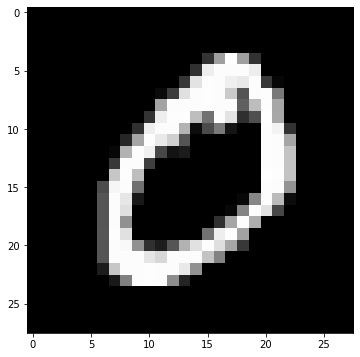

0


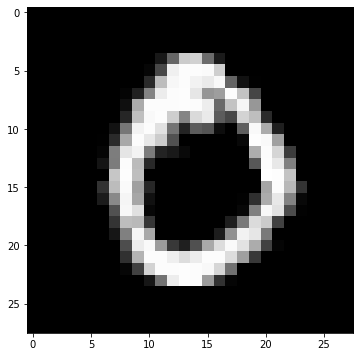

0


In [6]:
im_list = [train_images[i] for i in range(0,train_images.shape[0])] + [test_images[i] for i in range(0,test_images.shape[0])]
print(len(im_list))
print(type(im_list))

train_deskewed = [deskew(im) for im in im_list[0:train_images.shape[0]]]
test_deskewed = [deskew(im) for im in im_list[train_images.shape[0]:]]

print(type (train_deskewed))
train_deskewed = np.asarray(train_deskewed)
print(type (train_deskewed))

test_deskewed = np.asarray(test_deskewed)

showOpencvImage(train_images[1])
print(train_labels[1])

showOpencvImage(train_deskewed[1])
print(train_labels[1])



In [7]:
# normal
print("\n NORMAL:")
hogdata = [openCVHOG(im) for im in im_list]
print(len(hogdata))
print(hogdata[0].shape)
imData = np.float32(hogdata).reshape(-1,81)
print(imData.shape)

#deskewed
print("\n DESKEWED TRAIN:")
hogdata_train_deskewed = [openCVHOG(im) for im in train_deskewed]
print(len(hogdata_train_deskewed))
print(hogdata_train_deskewed[0].shape)
imData_train_deskewed = np.float32(hogdata_train_deskewed).reshape(-1,81)
print(imData_train_deskewed.shape)

print("\n DESKEWED TEST:")
hogdata_test_deskewed = [openCVHOG(im) for im in test_deskewed]
print(len(hogdata_test_deskewed))
print(hogdata_test_deskewed[0].shape)
imData_test_deskewed = np.float32(hogdata_test_deskewed).reshape(-1,81)
print(imData_test_deskewed.shape)


 NORMAL:
70000
(81,)
(70000, 81)

 DESKEWED TRAIN:
60000
(81,)
(60000, 81)

 DESKEWED TEST:
10000
(81,)
(10000, 81)


In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

nsamples, nx, ny = train_images.shape
train_images = train_images.reshape((nsamples, nx*ny))
print(train_images.shape)


parameters = {'kernel':('linear', 'rbf'), 'C': range(1,15), 'gamma': np.arange(1,2, 0.1)}
svc = SVC(max_iter=10000)
# model = SVC(C=15.5,gamma=0.7)
clf = GridSearchCV(svc, parameters, cv=3)
clf.fit(train_images[0:200], train_labels[0:200])
print(clf.best_estimator_)
print(clf.best_score_)
print(clf.best_params_)

model = SVC(C=1,gamma=1.0)

model.fit(imData[0:600,:],train_labels[0:600])

pred_labels = model.predict(imData[600:1000,:])

#deskewed
model_deskewed = SVC(C=15.5,gamma=0.7)
model_deskewed = model_deskewed.fit(imData_train_deskewed[0:600,:],train_labels[0:600])

pred_labels_deskewed = model.predict(imData_train_deskewed[600:1000,:])


(60000, 784)
SVC(C=1, gamma=1.0, kernel='linear', max_iter=10000)
0.8249660786974221
{'C': 1, 'gamma': 1.0, 'kernel': 'linear'}


In [9]:
from sklearn.metrics import classification_report, confusion_matrix

print("\n NORMAL:")
mask = pred_labels==train_labels[600:1000]
correct = np.count_nonzero(mask)
print(correct*100.0/pred_labels.size)

cm = confusion_matrix(train_labels[600:1000], pred_labels)
print(cm)
print(classification_report(train_labels[600:1000], pred_labels))


# deskewed
print("\n DESKEWED:")
mask_deskewed = pred_labels_deskewed ==train_labels[600:1000]
correct_deskewed = np.count_nonzero(mask_deskewed)
print(correct_deskewed*100.0/pred_labels_deskewed.size)

cm = confusion_matrix(train_labels[600:1000], pred_labels_deskewed)
print(cm)
print(classification_report(train_labels[600:1000], pred_labels_deskewed))


 NORMAL:
88.5
[[38  0  0  0  0  0  1  0  0  0]
 [ 0 34  3  0  0  0  0  0  0  0]
 [ 0  0 32  0  0  0  0  2  0  1]
 [ 0  0  2 31  0  1  0  0  0  0]
 [ 0  0  1  0 38  2  3  0  0  2]
 [ 0  0  2  1  0 36  0  0  1  1]
 [ 1  1  1  0  0  1 35  0  1  0]
 [ 0  0  2  2  1  0  0 49  0  1]
 [ 0  2  1  1  0  1  0  0 32  1]
 [ 4  0  0  0  0  0  1  1  0 29]]
              precision    recall  f1-score   support

           0       0.88      0.97      0.93        39
           1       0.92      0.92      0.92        37
           2       0.73      0.91      0.81        35
           3       0.89      0.91      0.90        34
           4       0.97      0.83      0.89        46
           5       0.88      0.88      0.88        41
           6       0.88      0.88      0.88        40
           7       0.94      0.89      0.92        55
           8       0.94      0.84      0.89        38
           9       0.83      0.83      0.83        35

    accuracy                           0.89       400
   m


*   **PRECISION** = TP / (TP+FP)
*   **RECALL** = TP + (TP+FN)
*   **F1 score** = 2*PRECISION*RECALL/(PRECISION+RECALL)
*   **ACCURACY** = SUM_OF_DIAGNONAL ELEMENTS/SUM OF ALL ELEMENTS
*   **Macro_AVG OF PRECISION** = SUM OF PRECISIONS/NUMBER OF CLASSES
*   **Weighted AVG OF PRECISION** = SUM OVER CLASSES PRECISION(CLASS)*WEIGHT*   (CLASS),
**WEIGHT** = CLASS SUPPORT/ALL ELEMENTS
*   **MICRO AVG OF PRECISION** = SUM (TP(CLASS))/SUM(TP(CLASS)+FP(CLASS))
   



In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

print("\n NORMAL:")
parameters = {'max_depth': range(10,20), 'n_estimators': range(90,110), 'max_features': range(55,65)}
rf = RandomForestClassifier(n_estimators=10)

clf = GridSearchCV(rf, parameters, cv=3)
clf.fit(train_images[0:200], train_labels[0:200])
print(clf.best_estimator_)
print(clf.best_score_)
print(clf.best_params_)
# rfc =  RandomForestClassifier(max_depth=15, n_estimators=100, max_features=60)
# rfc = rfc.fit(imData[0:600,:],train_labels[0:600])

# pred_labels = rfc.predict(imData[600:1000,:])

# mask = pred_labels==train_labels[600:1000]
# correct = np.count_nonzero(mask)
# print(correct*100.0/pred_labels.size)

# cm = confusion_matrix(train_labels[600:1000], pred_labels)
# print(cm)
# print(classification_report(train_labels[600:1000], pred_labels))


# #deskewed
# print("\n DESKEWED:")
# rfc_deskewed = RandomForestClassifier(max_depth=15, n_estimators=100, max_features=60)
# rfc_deskewed = rfc_deskewed.fit(imData_train_deskewed[0:600,:],train_labels[0:600])

# pred_labels_deskewed = rfc_deskewed.predict(imData_train_deskewed[600:1000,:])

# mask_deskewed = pred_labels_deskewed==train_labels[600:1000]
# correct_deskewed = np.count_nonzero(mask_deskewed)
# print(correct_deskewed*100.0/pred_labels_deskewed.size)

# cm = confusion_matrix(train_labels[600:1000], pred_labels_deskewed)
# print(cm)
# print(classification_report(train_labels[600:1000], pred_labels_deskewed))


 NORMAL:
RandomForestClassifier(max_depth=15, max_features=58, n_estimators=104)
0.8548922056384743
{'max_depth': 15, 'max_features': 58, 'n_estimators': 104}
